In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

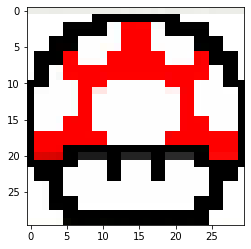

In [ ]:
img = Image.fromarray(np.asarray(Image.open('mariomushroom.jpg'))[250:750,150:600])
img = img.resize((30,30), resample = Image.NEAREST)
img = np.asarray(img)
img = img[5:25,5:25,...]
plt.imshow(img, vmin=0, vmax=255)

In [3]:
import scipy
dim = img.shape[0] * img.shape[1]
weights = np.zeros((dim, dim))
weights.shape

(900, 900)

In [4]:
DIST_PARAM = 5
sigma_squared_i = 400
sigma_squared_x = 50

for i in range(weights.shape[0]):
    i_row, i_col = i // img.shape[0], i % img.shape[1]
    for row_offset in range(-min(DIST_PARAM, i_row), min(DIST_PARAM + 1, img.shape[0] - i_row)):
        j_row = i_row + row_offset
        for col_offset in range(-min(DIST_PARAM, i_col), min(DIST_PARAM + 1, img.shape[1] - i_col)):
            j_col = i_col + col_offset
            dist = abs(row_offset) + abs(col_offset)
            if dist > 2*DIST_PARAM:
                print("ERROR")
                print(dist)
            j = j_row * img.shape[1] + j_col
            intensity_exp = (np.linalg.norm(np.array(img[j_row, j_col] - img[i_row, i_col]))**2)/sigma_squared_i
            distance_exp = dist**2/sigma_squared_x
            weights[i,j] = np.exp(-intensity_exp - distance_exp)

In [5]:
weights.shape

(900, 900)

In [6]:
import cvxpy as cvx

X = cvx.Variable((dim, dim), PSD=True)
obj = cvx.trace(weights @ X)
constr = [cvx.diag(X) == 1, cvx.sum(X) <= 0.15*dim*dim]
problem = cvx.Problem(cvx.Maximize(obj), constraints=constr)
problem.solve(solver=cvx.SCS, verbose=True, max_iters = 2500)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 11 08:02:29 PM: Your problem has 810000 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 11 08:02:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 11 08:02:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 11 08:02:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 11 08:02:29 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 11 08:02:29 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> C

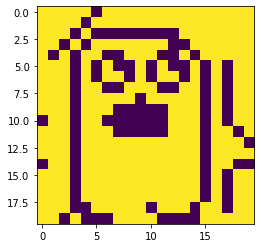

In [ ]:
import math

# recover the original vectors
sol = X.value
S, eig, S_T = np.linalg.svd(X.value)
V = np.transpose(S * np.sqrt(eig))  

# do the random hyperplane rounding
random_hyperplane_rounding = np.random.randn(dim)
# rearrange the cut to form an image again
cut = np.sign(random_hyperplane_rounding @ V).reshape(int(math.sqrt(dim)), int(math.sqrt(dim)), order = 'C')
#display the image
plt.imshow((cut+1)*125)

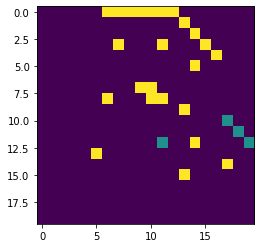

In [ ]:
num_cuts = 5
max_dot_product_rounding = np.random.randn(num_cuts, dim)
angles = np.abs(max_dot_product_rounding @ V)
partitions = np.argmax(angles, axis = 0).reshape(int(math.sqrt(dim)), int(math.sqrt(dim)), order = 'C')
plt.imshow(partitions*125)

In [ ]:
weights = np.array(weights)
def select_random_edge(weights):
    weights_prob = weights/np.sum(weights)
    val = np.random.choice(weights.flatten(), p = weights_prob.flatten())
    result = np.where(weights == val)
    ls = list(zip(result[0], result[1]))
    coord = ls[np.random.randint(len(ls))]
    return coord

def contract_edge(weights, p1, p2):
    
    new_weights = weights
    
    if p1 == p2:
        print("ERROR")
        return weights
    
    #shift weight
    for i in range(len(weights)):
        #move weight ending at p2
        new_weights[i][p1] += weights[i][p2]
        new_weights[i][p2] = 0

        #move weight starting at p2
        new_weights[p1][i] += weights[p2][i]
        new_weights[p2][i] = 0
    
    #weights = np.delete(weights, p2, axis=0)
    #weights = np.delete(weights, p2, axis=1)
    
    #remove self loops
    for i in range(len(weights)):
        new_weights[i][i] = 0
    
    return new_weights
    

print(np.sum(weights))
k = 2
vertices = len(weights)
groups = np.arange(0,len(weights),1)

num_steps = 0

while num_steps < vertices - k:
    i, j = select_random_edge(weights)
    groups[j] = i
    weights = contract_edge(weights, i, j)
    num_steps += 1

print(np.sum(weights))

  (0, 0)	1.0
  (0, 1)	0.9801986733067553
  (0, 2)	0.9231163463866358
  (0, 3)	0.835270211411272
  (0, 4)	0.7261490370736909
  (0, 5)	1.0952921331247048e-12
  (0, 6)	2.0561157132396143e-39
  (0, 7)	1.5853712812890272e-39
  (0, 8)	1.1744719317244356e-39
  (0, 9)	8.359542659191245e-40
  (0, 10)	5.716768623285355e-40
  (0, 20)	0.9801986733067553
  (0, 21)	0.9231163463866358
  (0, 22)	0.835270211411272
  (0, 23)	0.7261490370736909
  (0, 24)	1.0952921331247048e-12
  (0, 25)	2.347348336433542e-68
  (0, 26)	9.42745989004109e-72
  (0, 27)	6.984034061288425e-72
  (0, 28)	4.971028177988304e-72
  (0, 29)	3.399494335033427e-72
  (0, 30)	2.2336269418130425e-72
  (0, 40)	0.9231163463866358
  (0, 41)	0.835270211411272
  (0, 42)	0.7261490370736909
  :	:
  (399, 357)	6.212831603920532e-19
  (399, 358)	0.835270211411272
  (399, 359)	0.9231163463866358
  (399, 369)	3.7356518143175023e-240
  (399, 370)	1.4340275083114333e-182
  (399, 371)	2.324728045506799e-248
  (399, 372)	3.2734608316359222e-245
  (399, 

TypeError: len() of unsized object

In [ ]:
def set_to_groups(groups):
    groups_temp = np.zeros(len(groups))
    for i in range(len(groups)):
        ind = i
        val = groups[ind]
        while ind != val:
            ind = val
            val = groups[ind]
        groups_temp[i] = val
    return groups_temp

print(groups)    
res = set_to_groups(groups)
print(res)

for i in range(len(groups)):
    if i == groups[i]:
        print(i)

[114 255  20  20   0 250 114  55  92 124 252   8  49   7  44   7 220 279
 260  69   0   5   0  63  21   4  96  88 104 130  47 287  48 260  92 260
  31  26 104  57 380  31  20   5  66 301 124  43  26 236  48  27  29  90
 260 132   8  35 113 112 180  24  20 296  24 243 210 209 104 265  28 125
  51  54  33  69 196  56 217 266  44 359 117   0   4  43  81  43 264   9
 229 109  81  34 156  56 124 245 113  95 112  59 100  21  21 103 235 180
   4 106  69 104  52  56  23 125 191  36 132  18  41 120  80  82  21 149
 286 107 124 126 124  68 166  72  76  98  79  98 234  78  20  49  63  17
 206   7 343  49  90  37  43 251 225  34  91  69 334 322 113  59 260 141
 200  21 146 144 234  40  44  83 252  71 116   7 134  99  94 115 338 116
 106 398 221 206  62 280   6 185   7 360 167 225  96 146  76  83 149 362
 398 199 147 280 260 262 105 148  88 247 210   4 252  31 216 216 340 281
 235 388 218 219 360  44 130 240 262  14  69 250 253 247 252 214  33 307
 232  29  19 238 322  78 214 268 279 292 124 240  2